## 生成对抗- 网络
### 生成对抗网络模型
<img src="./image/GAN.jpg" style='zoom:80%'>

## 网络架构

### 输入层 ：待生成图像（噪音）和真实数据

### 生成网络：将噪音图像进行生成

### 判别网络：
- （1）判断真实图像输出结果 
- （2）判断生成图像输出结果

### 目标函数：
- （1）对于生成网络要使得生成结果通过判别网络为真 
- （2）对于判别网络要使得输入为真实图像时判别为真 输入为生成图像时判别为假

<img src="./image/2.png" alt="FAO" width="590" >


### 生成网络

```
生成模型G是根据已经捕捉的样本数据分布模式通过最大似然估计的方式生成fake样本。生成模型的目标是在检验网络确定的情况下，生成的fake样本经过判别模型的验证为真。
```

### 判别模型

```
判别模型D是二分类模型，其目标是捕捉真实样本数据分布模型并能够识别出生成模型的fake样本，即识别fake样本数据为假,识别真实样本数据为真。
```

### 生成对抗网络流程

```
1. 初始化生成器G 和 判别器D 
2. 循环迭代过程：
   1. 固定生成器，只更新判别器的超参。输入等量的真实数据集和生成器生成的数据集，对于真实数据集判别为真，对于生成器G产生的数据集判别为假
   
   2. 固定判别器，只更新生成器的超参。输入等量的真实数据集和生成器生成的数据集，对于真实数据集合生成器G产生的数据集判别为真。

```

<img src="./image/3.png" alt="FAO" width="590" >

- 判别器 : 火眼金睛，分辨出生成和真实的 <br /> 
<br /> 
- 生成器 : 瞒天过海，骗过判别器 <br /> 
<br /> 
- 损失函数定义 : 一方面要让判别器分辨能力更强，另一方面要让生成器更真 <br /> 
<br /> 

<img src="./image/1.jpg" alt="FAO" width="590" >

## Tensorflow实现GAN网络实例

In [3]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import numpy as np
import pickle
import matplotlib.pyplot as plt

%matplotlib inline

In [5]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('/data')

Extracting /data\train-images-idx3-ubyte.gz
Extracting /data\train-labels-idx1-ubyte.gz
Extracting /data\t10k-images-idx3-ubyte.gz
Extracting /data\t10k-labels-idx1-ubyte.gz


输入数据

In [6]:
#真实数据和噪音数据
def get_inputs(real_size, noise_size):
    
    real_img = tf.placeholder(tf.float32, [None, real_size])
    noise_img = tf.placeholder(tf.float32, [None, noise_size])
    
    return real_img, noise_img

#### tf.layers.dense()函数使用方法
```
dense ：全连接层  相当于添加一个层
函数如下：
tf.layers.dense(
    inputs,
    units,
    activation=None,
    use_bias=True,
    kernel_initializer=None,  ##卷积核的初始化器
    bias_initializer=tf.zeros_initializer(),  ##偏置项的初始化器，默认初始化为0
    kernel_regularizer=None,    ##卷积核的正则化，可选
    bias_regularizer=None,    ##偏置项的正则化，可选
    activity_regularizer=None,   ##输出的正则化函数
    kernel_constraint=None,   
    bias_constraint=None,
    trainable=True,
    name=None,  ##层的名字
    reuse=None  ##是否重复使用参数
)

部分参数解释：
inputs：输入该网络层的数据
units：输出的维度大小，改变inputs的最后一维
activation：激活函数，即神经网络的非线性变化
use_bias：使用bias为True（默认使用），不用bias改成False即可，是否使用偏置项
trainable=True:表明该层的参数是否参与训练。如果为真则变量加入到图集合中
 GraphKeys.TRAINABLE_VARIABLES (see tf.Variable)
在其他网站上看到的使用现象
dense1 = tf.layers.dense(inputs=pool3, units=1024, activation=tf.nn.relu，                                
                                           kernel_regularizer=tf.contrib.layers.l2_regularizer(0.003))
#全连接层

dense1 = tf.layers.dense(inputs=pool3, units=1024, activation=tf.nn.relu)
dense2= tf.layers.dense(inputs=dense1, units=512, activation=tf.nn.relu)
logits= tf.layers.dense(inputs=dense2, units=10, activation=None)
```

###  生成器

In [7]:
def get_generator(noise_img, n_units, out_dim, reuse=False, alpha=0.01):
  
    with tf.variable_scope("generator", reuse=reuse):
        # hidden layer
        hidden1 = tf.layers.dense(noise_img, n_units)
        # leaky ReLU  对于得分值小于0的像素点舍弃
        hidden1 = tf.maximum(alpha * hidden1, hidden1)
        # dropout
        hidden1 = tf.layers.dropout(hidden1, rate=0.2)

        # logits & outputs
        logits = tf.layers.dense(hidden1, out_dim)
        outputs = tf.tanh(logits)
        
        return logits, outputs

### 判别器

In [8]:
def get_discriminator(img, n_units, reuse=False, alpha=0.01):

    with tf.variable_scope("discriminator", reuse=reuse):
        # hidden layer
        hidden1 = tf.layers.dense(img, n_units)
        hidden1 = tf.maximum(alpha * hidden1, hidden1)
        
        # logits & outputs
        logits = tf.layers.dense(hidden1, 1)
        outputs = tf.sigmoid(logits)
        
        return logits, outputs

###  网络参数定义
* img_size：输入大小
* noise_size：噪音图像大小
* g_units：生成器隐层参数
* d_units：判别器隐层参数
* learning_rate：学习率

In [9]:
img_size = mnist.train.images[0].shape[0]

noise_size = 100

g_units = 128

d_units = 128

learning_rate = 0.001

alpha = 0.01

### 网络构建

In [11]:
tf.reset_default_graph()

real_img, noise_img = get_inputs(img_size, noise_size)

# generator
g_logits, g_outputs = get_generator(noise_img, g_units, img_size)

# discriminator  
d_logits_real, d_outputs_real = get_discriminator(real_img, d_units)   #判别器判别原图的损失值
d_logits_fake, d_outputs_fake = get_discriminator(g_outputs, d_units, reuse=True) #判别器判别生成图的得分值

In [13]:
# discriminator的loss
# 识别真实图片
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                                     labels=tf.ones_like(d_logits_real)))
# 识别生成的图片
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                     labels=tf.zeros_like(d_logits_fake)))
# 总体loss
d_loss = tf.add(d_loss_real, d_loss_fake)

# generator的loss
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                labels=tf.ones_like(d_logits_fake)))

In [14]:
train_vars = tf.trainable_variables()

# generator
g_vars = [var for var in train_vars if var.name.startswith("generator")]
# discriminator
d_vars = [var for var in train_vars if var.name.startswith("discriminator")]

# optimizer
d_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)
g_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)

### 模型训练

In [15]:
# batch_size
batch_size = 64
# 训练迭代轮数
epochs = 300
# 抽取样本数
n_sample = 25

# 存储测试样例
samples = []
# 存储loss
losses = []
# 保存生成器变量
saver = tf.train.Saver(var_list = g_vars)
# 开始训练
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for batch_i in range(mnist.train.num_examples//batch_size):
            batch = mnist.train.next_batch(batch_size)
            
            batch_images = batch[0].reshape((batch_size, 784))
            # 对图像像素进行scale，这是因为tanh输出的结果介于(-1,1),real和fake图片共享discriminator的参数
            batch_images = batch_images*2 - 1
            
            # generator的输入噪声
            batch_noise = np.random.uniform(-1, 1, size=(batch_size, noise_size))
            
            # Run optimizers
            _ = sess.run(d_train_opt, feed_dict={real_img: batch_images, noise_img: batch_noise})
            _ = sess.run(g_train_opt, feed_dict={noise_img: batch_noise})
        
        # 每一轮结束计算loss
        train_loss_d = sess.run(d_loss, 
                                feed_dict = {real_img: batch_images, 
                                             noise_img: batch_noise})
        # real img loss
        train_loss_d_real = sess.run(d_loss_real, 
                                     feed_dict = {real_img: batch_images, 
                                                 noise_img: batch_noise})
        # fake img loss
        train_loss_d_fake = sess.run(d_loss_fake, 
                                    feed_dict = {real_img: batch_images, 
                                                 noise_img: batch_noise})
        # generator loss
        train_loss_g = sess.run(g_loss, 
                                feed_dict = {noise_img: batch_noise})
        
            
        print("Epoch {}/{}...".format(e+1, epochs),
              "判别器损失: {:.4f}(判别真实的: {:.4f} + 判别生成的: {:.4f})...".format(train_loss_d, train_loss_d_real, train_loss_d_fake),
              "生成器损失: {:.4f}".format(train_loss_g))    
        
        losses.append((train_loss_d, train_loss_d_real, train_loss_d_fake, train_loss_g))
        
        # 保存样本
        sample_noise = np.random.uniform(-1, 1, size=(n_sample, noise_size))
        gen_samples = sess.run(get_generator(noise_img, g_units, img_size, reuse=True),
                               feed_dict={noise_img: sample_noise})
        samples.append(gen_samples)
        
        
        saver.save(sess, './checkpoints/generator.ckpt')

# 保存到本地
with open('train_samples.pkl', 'wb') as f:
    pickle.dump(samples, f)

Epoch 1/300... 判别器损失: 0.0215(判别真实的: 0.0026 + 判别生成的: 0.0189)... 生成器损失: 4.6264
Epoch 2/300... 判别器损失: 0.3395(判别真实的: 0.1424 + 判别生成的: 0.1970)... 生成器损失: 4.5716
Epoch 3/300... 判别器损失: 1.7263(判别真实的: 0.5533 + 判别生成的: 1.1730)... 生成器损失: 2.5512
Epoch 4/300... 判别器损失: 0.7726(判别真实的: 0.4291 + 判别生成的: 0.3435)... 生成器损失: 5.8328
Epoch 5/300... 判别器损失: 1.2701(判别真实的: 0.5137 + 判别生成的: 0.7563)... 生成器损失: 1.3971
Epoch 6/300... 判别器损失: 1.0193(判别真实的: 0.6663 + 判别生成的: 0.3530)... 生成器损失: 2.0586
Epoch 7/300... 判别器损失: 1.2822(判别真实的: 0.8590 + 判别生成的: 0.4232)... 生成器损失: 2.5830
Epoch 8/300... 判别器损失: 1.9247(判别真实的: 1.2229 + 判别生成的: 0.7018)... 生成器损失: 2.4829
Epoch 9/300... 判别器损失: 0.7210(判别真实的: 0.5389 + 判别生成的: 0.1821)... 生成器损失: 3.5317
Epoch 10/300... 判别器损失: 1.1588(判别真实的: 0.3576 + 判别生成的: 0.8012)... 生成器损失: 1.7931
Epoch 11/300... 判别器损失: 0.8575(判别真实的: 0.5838 + 判别生成的: 0.2737)... 生成器损失: 2.3082
Epoch 12/300... 判别器损失: 0.9520(判别真实的: 0.6369 + 判别生成的: 0.3151)... 生成器损失: 3.7391
Epoch 13/300... 判别器损失: 1.2660(判别真实的: 1.0109 + 判别生成的: 0.2551)... 生成器损失: 3.

Epoch 107/300... 判别器损失: 0.6793(判别真实的: 0.2704 + 判别生成的: 0.4088)... 生成器损失: 1.9071
Epoch 108/300... 判别器损失: 0.8691(判别真实的: 0.4391 + 判别生成的: 0.4300)... 生成器损失: 1.8126
Epoch 109/300... 判别器损失: 0.8308(判别真实的: 0.4829 + 判别生成的: 0.3479)... 生成器损失: 1.8955
Epoch 110/300... 判别器损失: 0.9360(判别真实的: 0.6367 + 判别生成的: 0.2993)... 生成器损失: 1.9054
Epoch 111/300... 判别器损失: 0.9323(判别真实的: 0.5192 + 判别生成的: 0.4131)... 生成器损失: 1.5596
Epoch 112/300... 判别器损失: 0.9440(判别真实的: 0.4840 + 判别生成的: 0.4600)... 生成器损失: 1.7705
Epoch 113/300... 判别器损失: 0.9635(判别真实的: 0.4486 + 判别生成的: 0.5149)... 生成器损失: 1.5800
Epoch 114/300... 判别器损失: 0.8551(判别真实的: 0.3869 + 判别生成的: 0.4682)... 生成器损失: 1.5565
Epoch 115/300... 判别器损失: 0.9568(判别真实的: 0.3843 + 判别生成的: 0.5725)... 生成器损失: 1.3093
Epoch 116/300... 判别器损失: 1.0425(判别真实的: 0.6255 + 判别生成的: 0.4170)... 生成器损失: 1.5158
Epoch 117/300... 判别器损失: 0.9500(判别真实的: 0.4089 + 判别生成的: 0.5411)... 生成器损失: 1.4671
Epoch 118/300... 判别器损失: 1.0417(判别真实的: 0.5737 + 判别生成的: 0.4679)... 生成器损失: 1.5585
Epoch 119/300... 判别器损失: 0.9758(判别真实的: 0.5495 + 判别生成的

Epoch 211/300... 判别器损失: 0.9829(判别真实的: 0.4357 + 判别生成的: 0.5472)... 生成器损失: 1.5963
Epoch 212/300... 判别器损失: 0.9922(判别真实的: 0.3185 + 判别生成的: 0.6738)... 生成器损失: 1.2918
Epoch 213/300... 判别器损失: 0.9786(判别真实的: 0.4947 + 判别生成的: 0.4839)... 生成器损失: 1.4432
Epoch 214/300... 判别器损失: 0.9203(判别真实的: 0.4630 + 判别生成的: 0.4573)... 生成器损失: 1.5313
Epoch 215/300... 判别器损失: 0.9338(判别真实的: 0.4433 + 判别生成的: 0.4906)... 生成器损失: 1.5633
Epoch 216/300... 判别器损失: 1.0868(判别真实的: 0.6436 + 判别生成的: 0.4432)... 生成器损失: 1.7303
Epoch 217/300... 判别器损失: 1.0388(判别真实的: 0.5074 + 判别生成的: 0.5314)... 生成器损失: 1.4665
Epoch 218/300... 判别器损失: 0.8831(判别真实的: 0.4139 + 判别生成的: 0.4692)... 生成器损失: 1.6524
Epoch 219/300... 判别器损失: 0.9030(判别真实的: 0.4760 + 判别生成的: 0.4270)... 生成器损失: 1.6903
Epoch 220/300... 判别器损失: 0.9394(判别真实的: 0.4802 + 判别生成的: 0.4592)... 生成器损失: 1.5448
Epoch 221/300... 判别器损失: 0.9971(判别真实的: 0.4023 + 判别生成的: 0.5948)... 生成器损失: 1.4886
Epoch 222/300... 判别器损失: 1.0867(判别真实的: 0.4545 + 判别生成的: 0.6323)... 生成器损失: 1.2666
Epoch 223/300... 判别器损失: 0.8255(判别真实的: 0.3331 + 判别生成的

### 损失曲线

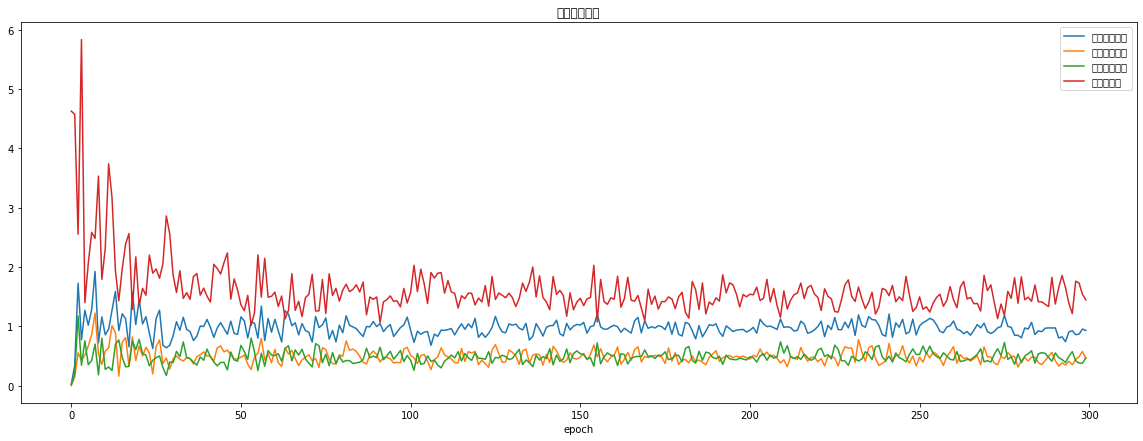

In [16]:
fig, ax = plt.subplots(figsize=(20,7))
losses = np.array(losses)
plt.plot(losses.T[0], label='判别器总损失')
plt.plot(losses.T[1], label='判别真实损失')
plt.plot(losses.T[2], label='判别生成损失')
plt.plot(losses.T[3], label='生成器损失')
plt.title("对抗生成网络")
ax.set_xlabel('epoch')
plt.legend()

### 生成结果

In [17]:
# Load samples from generator taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pickle.load(f)
    
#samples是保存的结果 epoch是第多少次迭代
def view_samples(epoch, samples):
    
    fig, axes = plt.subplots(figsize=(7,7), nrows=5, ncols=5, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch][1]): # 这里samples[epoch][1]代表生成的图像结果，而[0]代表对应的logits
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')
    
    return fig, axes

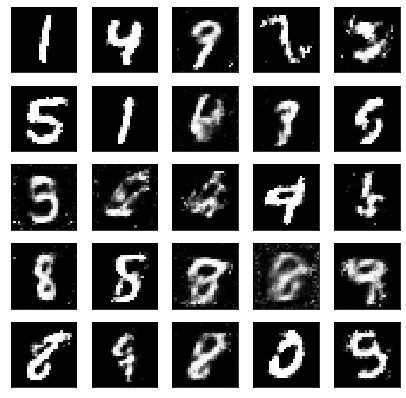

In [18]:
_ = view_samples(-1, samples) # 显示最终的生成结果

### 显示图片生成过程

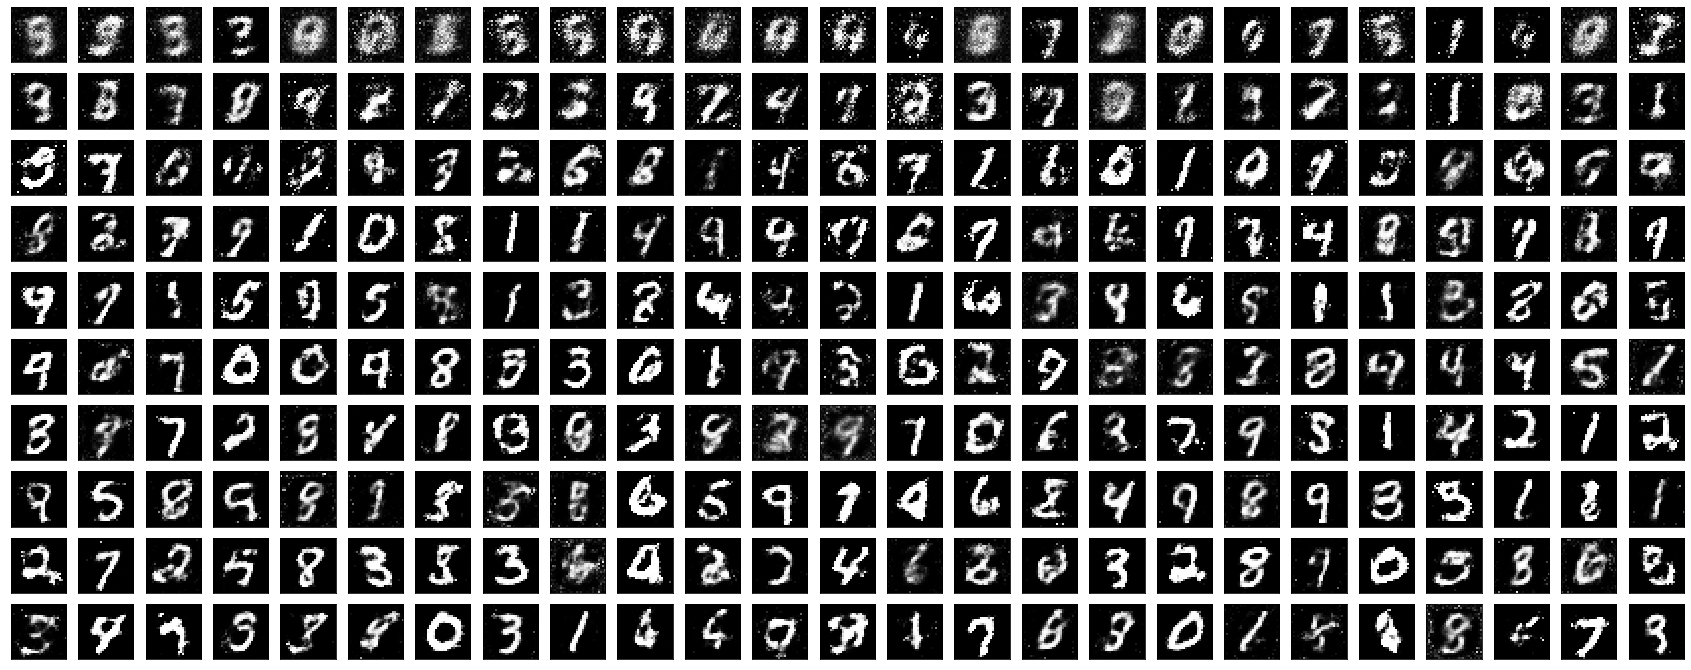

In [20]:
# 指定要查看的轮次
epoch_idx = [10, 30, 60, 90, 120, 150, 180, 210, 240, 290] 
show_imgs = []
for i in epoch_idx:
    show_imgs.append(samples[i][1])

# 指定图片形状
rows, cols = 10, 25
fig, axes = plt.subplots(figsize=(30,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

idx = range(0, epochs, int(epochs/rows))

for sample, ax_row in zip(show_imgs, axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

### 显示生成的新图片

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from checkpoints\generator.ckpt


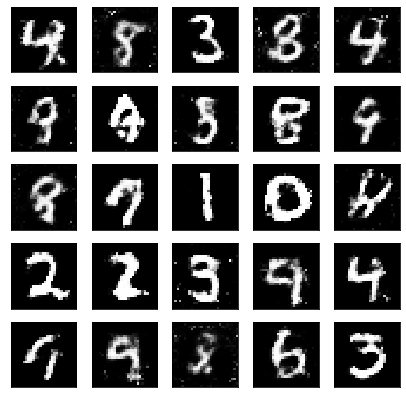

In [21]:
# 加载我们的生成器变量
saver = tf.train.Saver(var_list=g_vars)
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    sample_noise = np.random.uniform(-1, 1, size=(25, noise_size))
    gen_samples = sess.run(get_generator(noise_img, g_units, img_size, reuse=True),
                           feed_dict={noise_img: sample_noise})

_ = view_samples(0, [gen_samples])

## Pytorch实现对抗生成网络

In [2]:
import torch
from torchvision import datasets,transforms 
batch_size = 64
# 训练集
train_dataset = datasets.MNIST(root='./data',  
                            train=True,   
                            transform=transforms.ToTensor(),  
                            download=True) 

# 测试集
test_dataset = datasets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())

# 构建batch数据
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

In [9]:
from torch import nn
import torch.nn.functional as F

# 定义生成网络模型
class GAN_GENERATER(nn.Module):
    def __init__(self,fake_input_size,out_dim):
        super(GAN_GENERATER,self).__init__()
        self.hidden = nn.Linear(fake_input_size,128)
        self.out    = nn.Linear(128,out_dim)
    
    def forward(self,x):
        x = F.relu(self.hidden(x))
        x = F.dropout(x,p=0.2)
        logists = self.out(x)
        outputs = F.tanh(logists)
        return logists,outputs

# 定义判别网络模型
class GAN_DSCRIMINATOR(nn.Module):
    def __init__(self,input_size,out_dim):
        super(GAN_DSCRIMINATOR,self).__init__()
        self.hidden = nn.Linear(input_size,128)
        self.out    = nn.Linear(128,out_dim)
    
    def forward(x,self):
        x = F.relu(self.hidden(x))
        logists = self.out(x)
        outputs = F.sigmoid(logists)
        return logists,outputs

In [10]:
import torch.optim as optim

# 生成模型
generater_input_size = 784
generater_out_dim = 784

discriminator_input_size = 784
discriminator_out_dim = 1

generater_model = GAN_GENERATER(generater_input_size,generater_out_dim)

discriminator_model = GAN_DSCRIMINATOR(discriminator_input_size,discriminator_out_dim)

# 定义损失函数
loss_func = nn.CrossEntropyLoss() 

# 选择优化器
generater_optimizer = optim.Adam(generater_model.parameters(),lr=0.01)
discriminator_optimizer = optim.Adam(discriminator_model.parameters(),lr=0.01)

In [11]:
def generater_loss(fake_image,loss_func):
    gen_logists,gen_outputs = discriminator_model(fake_image)
    gen_loss = loss_func(gen_outputs,torch.ones_like(fake_image.size()))
    return gen_loss

def discriminator_loss(fake_image,real_image,loss_func):
    gen_logists,gen_outputs = discriminator_model(fake_image) #使用fake_image生成判别器特征数据 
    dis_logists,dis_outputs = discriminator_model(real_image) #使用real_image生成判别器特征数据
    fake_loss = loss_func(gen_outputs,torch.zeros_like(gen_outputs.size())) # 计算fake损失值
    real_loss = loss_func(dis_outputs,torch.ones_like(dis_outputs))         #计算real损失值
    dis_loss =  fake_loss + real_loss                                             #
    return dis_loss

In [ ]:
num_epochs = 300
loss = [] #保存损失值
samples = [] #保存样本

for epoch in range(num_epochs):
    
    for batch_index,(data,labels) in enumerate(train_loader):
        
        batch_real = data.view(64,784)
        batch_real_image = batch_real*2 -1
        batch_fake = torch.randn(64,784)
        
        # step1 generater training
        generater_model.train()
        batch_fake_image = generater_model(batch_fake)
        gen_loss = generater_loss(batch_fake_image,loss_func)
        generater_optimizer.zero_grad()
        gen_loss.backward()
        generater_optimizer.step()
        
        # step2 discriminator training
        discriminator_model.train()
        dis_loss = discriminator_loss(batch_fake_image,batch_real_image,loss_func)
        discriminator_optimizer.zero_grad()
        dis_loss.backward()
        discriminator_optimizer.step()
        
        if batch_index == (len(train_loader)-1):
            loss.append((gen_loss,dis_loss))
            print("Epoch {}/{}   ".format(epoch+1, num_epochs),
                  "生成器损失值  ".format(gen_loss),
                  "判别器损失值  ".format(dis_loss)
            )
            
            sample_noise = torch.randn(10,784)
            gen_samples = generater_model(sample_noise)
            samples.append(gen_samples)  